### Things I will assume are familiar to you

1. Organizing single-cell data using AnnData `anndata.AnnData` ([**link**](https://anndata.readthedocs.io/en/latest/))
2. PyTorch Dataset class: `torch.utils.data.Dataset` ([**link**](https://pytorch.org/docs/stable/data.html))
3. PyTorch DataLoader class: `torch.utils.data.DataLoader` ([**link**](https://pytorch.org/docs/stable/data.html))


### Some stuff we might not have time to discuss
* Ready adaptation to PyTorch Lightning (`LightningDataModule`) ([**link**](https://lightning.ai/docs/pytorch/stable/data/datamodule.html))

### Install necessary packages & import libraries

In [42]:
# !pip install -q torch-adata

In [43]:
import torch_adata

### Start with some simple demo data: 10x PBMCs

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'cell_type_idx'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'cmap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


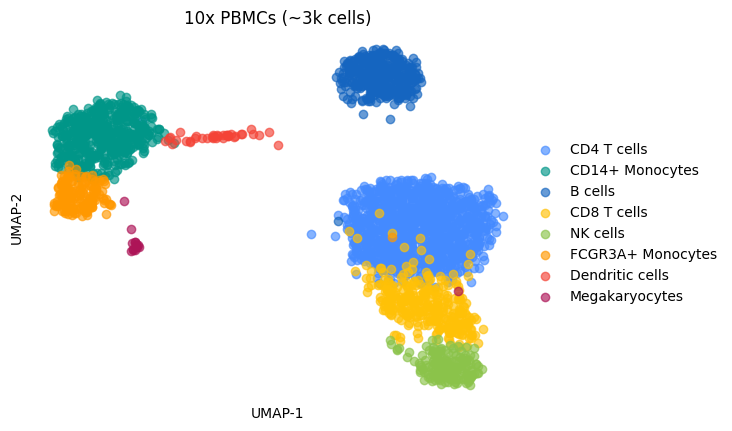

In [7]:
demo_data = torch_adata._demo.DemoData()
adata_pbmc = demo_data.PBMC3k

Simplest pass:

In [89]:

adata_pbmc.layers['X_norm'] = adata_pbmc.X

In [90]:
pbmc_dataset = torch_adata.AnnDataset(adata_pbmc, use_key = "X_norm")

[ torch-adata ]: AnnDataset object with 2638 samples
----------------------------------------------------
 - X (use_key = 'X_norm' torch.Size([2638, 1838]))


In [92]:
pbmc_dataset.X.shape

torch.Size([2638, 1838])

Use keys in `adata.obs` to access labels, etc.

In [93]:
pbmc_dataset = torch_adata.AnnDataset(adata_pbmc, use_key = "X_pca", obs_keys = ['louvain'])

[ torch-adata ]: AnnDataset object with 2638 samples
----------------------------------------------------
 - X (use_key = 'X_pca' torch.Size([2638, 50]))
 - obs:   louvain: torch.Size([2638, 8])


In [94]:
pbmc_dataset.X.shape, pbmc_dataset.louvain.shape

(torch.Size([2638, 50]), torch.Size([2638, 8]))

In [22]:
# notice that louvain labels have been one-hot encoded:
pbmc_dataset.louvain

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [95]:
import torch

In [24]:
train_dataset, val_dataset = torch_adata.tl.split(pbmc_dataset)

In [32]:
len(train_dataset.indices), len(val_dataset.indices)

(1319, 1319)

In [33]:
train_dataset, val_dataset, test_dataset = torch_adata.tl.split(pbmc_dataset, n_groups=3, percentages=[0.8, 0.1, 0.1])

In [36]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2110, 263, 265)

In [44]:
from torch.utils.data import DataLoader
import os

In [45]:
batch_size = 200
num_workers = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [46]:
X, y = next(iter(train_loader))
print(X.shape, y.shape)

torch.Size([200, 50]) torch.Size([200, 8])


In [47]:
from lightning import LightningDataModule

In [50]:
class LitData(LightningDataModule):
    def __init__(self):
        super()

    def setup(self):
        ...

    def prepare_data(self):
        self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
        self.val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

    def train_dataloader(self):
        return self.train_dataloader

    def val_dataloader(self):
        return self.val_dataloader

In [52]:
ld = LitData()
ld.train_dataloader()

<bound method LitData.train_dataloader of <__main__.LitData object at 0x7f7fafbe9a80>>

In [79]:
from lightning import LightningModule
import torch

class LightningCellClassifier(LightningModule):
    def __init__(self, net, lr=1e-3, loss_func=torch.nn.MSELoss()):

        super().__init__()
        self.net = net
        self.lr = lr
        self.loss_func = loss_func

    def forward(self, x, y):
        y_hat = torch.nn.functional.softmax(self.net(x), dim=1)
        loss = self.loss_func(y_hat, y)
        return y_hat, loss

    def training_step(self, batch, batch_idx):

        x, y = batch[0], batch[1]
        y_hat, loss = self.forward(x, y)
        self.log("train_loss", loss.item(), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):

        x, y = batch[0], batch[1]
        y_hat, loss = self.forward(x, y)
        self.log("val_loss", loss.item(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [80]:
net = torch.nn.Sequential(
    torch.nn.Linear(50, 200),
    torch.nn.Linear(200, 200),
    torch.nn.Linear(200, 8),
)

In [81]:
lit_classifier = LightningCellClassifier(net)

In [82]:
from lightning.pytorch.loggers import CSVLogger
from lightning import Trainer

save_dir = "./"

trainer = Trainer(
    accelerator="auto",
    logger=CSVLogger(save_dir=save_dir),
    devices=1,
    max_epochs=25,
    reload_dataloaders_every_n_epochs=1,
    log_every_n_steps=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [83]:
trainer.fit(lit_classifier, train_loader, val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type       | Params
-----------------------------------------
0 | net       | Sequential | 52.0 K
1 | loss_func | MSELoss    | 0     
-----------------------------------------
52.0 K    Trainable params
0         Non-trainable params
52.0 K    Total params
0.208     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | net       | Sequential | 52.0 K
1 | loss_func | MSELoss    | 0     
-----------------------------------------
52.0 K    Trainable params
0         Non-trainable params
52.0 K    Total params
0.208     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


### Add in a bit more complexity: multi-timepoint dataset

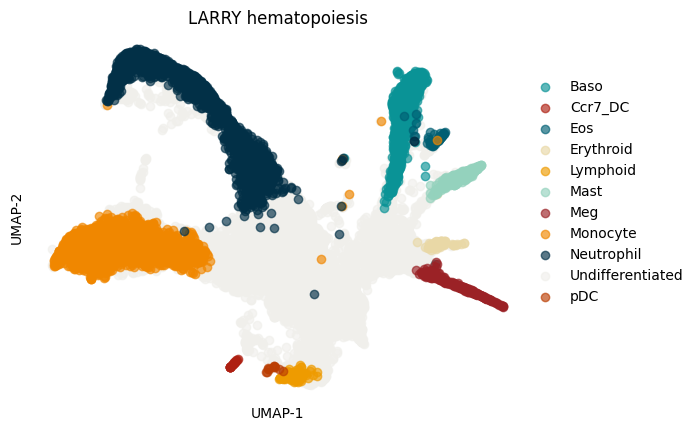

In [96]:
adata = demo_data.LARRY

In [98]:
adata

AnnData object with n_obs × n_vars = 13089 × 25289
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y'
    var: 'gene_name', 'pass_filter'
    uns: 'dataset', 'h5ad_path', 'cmap'
    obsm: 'X_clone', 'X_pca', 'X_scaled', 'X_umap'

In [104]:
adata.obs['rand'] = np.random.random(len(adata))

In [99]:
dataset = torch_adata.AnnDataset(adata, use_key = "X_pca")

[ torch-adata ]: AnnDataset object with 13089 samples
-----------------------------------------------------
 - X (use_key = 'X_pca' torch.Size([13089, 50]))


In [105]:
dataset = torch_adata.AnnDataset(adata, use_key = "X_pca", groupby="Time point", obs_keys=['rand'])

[ torch-adata ]: AnnDataset object with 5414 samples
----------------------------------------------------
Grouped by: 'Time point' with attributes:
 - X (use_key = 'X_pca' torch.Size([3, 5414, 50]))
 - obs:   rand: torch.Size([3, 5414, 1])


In [101]:
dataset.X.shape

torch.Size([3, 5414, 50])

In [102]:
adata.obs['Time point'].value_counts()

6.0    5414
4.0    4849
2.0    2826
Name: Time point, dtype: int64

In [106]:
torch_adata.tl.dummy_batch(dataset)

Batch:
------ 
 - X:  torch.Size([3])
 - rand:  torch.Size([3, 54, 50])


[tensor([2., 4., 6.]),
 tensor([[[-5.2809e+00,  1.7561e+00, -8.8028e-01,  ..., -8.4372e-01,
           -8.8706e-01, -9.2798e-02],
          [-7.3099e+00, -1.6094e-01,  5.0644e-01,  ..., -3.1997e-01,
           -5.4626e-01, -1.1842e-02],
          [-4.9330e+00, -1.7617e+00,  5.0724e-01,  ..., -6.2040e-01,
            7.1264e-02,  2.4256e-01],
          ...,
          [-7.0553e+00, -3.0296e-01,  2.4214e+00,  ...,  1.6829e-01,
            2.3536e-01, -2.1441e-01],
          [-4.6640e+00, -1.7730e+00,  6.4905e-02,  ...,  2.1341e+00,
           -1.6495e+00,  3.9112e-01],
          [-6.6170e+00, -1.4532e+00,  4.6145e-01,  ..., -5.0556e-03,
           -1.6111e-01, -5.7956e-01]],
 
         [[-5.9970e+00, -2.2829e-01,  1.9142e+00,  ..., -7.4806e-02,
            5.7506e-01, -6.1698e-01],
          [ 2.9212e+00, -6.0761e+00, -4.4188e+00,  ...,  1.9168e-01,
            1.1085e+00, -1.6666e-01],
          [ 9.9676e+00,  9.3946e-01,  1.1213e+01,  ...,  2.0558e+00,
           -5.7709e-01,  1.9975e-0